Submitted by: Robin Manchanda

Brampton, ON, L7A 2E2

robinm.ecil@gmail.com | 437-855-2344 | https://github.com/robmanch/Data-Science | https://www.linkedin.com/in/robinmanchanda

# Table of Content:
1. Import Libraries
2. Read Data
3. Feature Engineering
4. Exploratory Data Analysis
5. Feature Selection
6. Building Model
    - Ridge
    - Random Forest
    - Neural Network
7. Result
8. Prediction
9. Deployement

## 1. Import Libraries

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
import plotly_express as px
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.cluster import KElbowVisualizer

In [2]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from keras.callbacks import LearningRateScheduler
import math
import pickle

## 2. Read Data

In [3]:
df = pd.read_csv('data_train.csv')# read csv file
df.head()

,Order-Date,Delivery-Date,Promised-Date,Courier,Size of the box height,Size of the box width,Size of the box length,Size of the box weight,Weather,Store address,Customer address
0,2021-01-24,2021-01-27,2021-01-26,PS,29.632656,34.722553,17.523058,3.807421,Good,'-123.048/49.1534','-126.07325247944962/51.29548801984406'
1,2021-04-09,2021-04-13,2021-04-13,FD,29.632656,34.722553,17.523058,1.902088,Good,'-123.048/49.1534','-126.07255765553835/51.29486187466757'
2,2021-09-27,2021-10-02,2021-10-02,PS,29.632656,34.722553,17.523058,2.152103,Good,'-123.048/49.1534','-126.07443435490822/51.29566033167437'
3,2020-11-29,2020-12-04,2020-12-03,PS,29.632656,34.722553,17.523058,3.802455,Good,'-123.048/49.1534','-126.07310897909636/51.295612714656855'
4,2021-09-06,2021-09-12,2021-09-11,FD,29.632656,34.722553,17.523058,5.510081,Good,'-123.048/49.1534','-126.07309709870711/51.29454616285458'


### 2.1 Check Null Values

<Figure size 432x432 with 0 Axes>

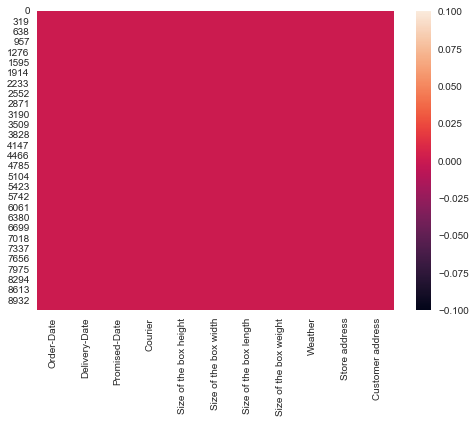

<Figure size 432x432 with 0 Axes>

In [4]:
sns.heatmap(df.isnull())# check null values
plt.figure(figsize=(6,6))

There are no null values in the dataset.

## 3. Feature Engineering

The dataset has certain features such as customer address, store address, order date, promised date, etc. that cannot be used directly as an input to the machine learning model. So these features are engineered and some new features have been created and these are explained below:
1. *Distance*: It represents the distance between customer and store address. It has been seen usually that the number of days required to ship a product increases with the distance. So, it could be an important feature to be considered in delivery optimization problems.

2. All the dates have been changed to pandas DateTime object

3. *Shipping_days* (Target Label): It is the number required to ship the product to the customer.

4. *Order_month*: To find the effect of the month on the shipping days.

In [5]:
def lat_long_format(x):
    """This function converts given 'longitude/latitude' string to 'latitude, longitude' string"""    
    tmp_list = x[1:-1].split('/') # split the string based on '/'
    long = tmp_list[0] # longitude
    lat = tmp_list[1] # latitude
    x = lat + ',' + long # 'latitude, langitude'
    return x

In [6]:
def distance(coordinate1, coordinate2):
    """This function calculates distance between two cordinates
    Input: Tuple of cordinates.
    Output: Distance in kilometers"""
#     print(coordinate1, coordinate2)
    distannce_in_km = geodesic(coordinate1, coordinate2).km #finding distance
    return distannce_in_km

In [7]:
def pandas_datetime(df, column):
    """This function converts str to pandas datetime object"""
    return pd.to_datetime(df[column])

In [8]:
def calculate_days(df, column1, column2):
    """This function calculates days between df[column1] and df[column2]"""
    days = (df[column1] - df[column2]).astype('str').apply(lambda d: int(d.split(' ')[0]))
    return days

In [9]:
def extract_lat_long(df, column, type_):
    """This function extract the latitude and longitude
    Input: Dataframe, Atribute
    Output: Latitude/Longitude"""
    if type_ == 'latitude':
        x = df[column].apply(lambda x: x.split(',')[0]).astype('float')# extract latitude
    else:
        x = df[column].apply(lambda x: x.split(',')[1]).astype('float')# extract longitude
        
    return x

In [10]:
def data_preprocess(df):
    
    df["Delivery-Date"] = pandas_datetime(df, "Delivery-Date") 
    df["Order-Date"] = pandas_datetime(df, "Order-Date") 
    df['shipping_days'] = calculate_days(df, "Delivery-Date", "Order-Date") # shipping days
    df['order_month'] = df['Order-Date'].dt.month_name().astype('str') # Month in which order was placed
    df['Store address'] = df['Store address'].apply(lat_long_format) # apply lat_long function to 'Store address' pandas series
    df['Customer address'] = df['Customer address'].apply(lat_long_format)
    
    for i in range(df.shape[0]):
        """Looping through the each row of the dataframe"""
        coordinate1 = df.loc[i,'Store address']
        coordinate2 = df.loc[i, 'Customer address']
        df.loc[i,'distance'] = distance(coordinate1, coordinate2)
        
    df['cust_lat'] = extract_lat_long(df, 'Customer address', 'latitude') # customer latitude
    df['cust_long'] = extract_lat_long(df, 'Customer address', 'longitude') # customer longitude
    df['store_lat'] = extract_lat_long(df, 'Store address', 'latitude') # Store latitude
    df['store_long'] = extract_lat_long(df, 'Store address', 'longitude') # Store longitude
    
    return df

In [11]:
df = data_preprocess(df)

In [12]:
df.head()

,Order-Date,Delivery-Date,Promised-Date,Courier,Size of the box height,Size of the box width,Size of the box length,Size of the box weight,Weather,Store address,Customer address,shipping_days,order_month,distance,cust_lat,cust_long,store_lat,store_long
0,2021-01-24,2021-01-27,2021-01-26,PS,29.632656,34.722553,17.523058,3.807421,Good,"49.1534,-123.048","51.29548801984406,-126.07325247944962",3,January,321.473027,51.295488,-126.073252,49.1534,-123.048
1,2021-04-09,2021-04-13,2021-04-13,FD,29.632656,34.722553,17.523058,1.902088,Good,"49.1534,-123.048","51.29486187466757,-126.07255765553835",4,April,321.389102,51.294862,-126.072558,49.1534,-123.048
2,2021-09-27,2021-10-02,2021-10-02,PS,29.632656,34.722553,17.523058,2.152103,Good,"49.1534,-123.048","51.29566033167437,-126.07443435490822",5,September,321.543559,51.295660,-126.074434,49.1534,-123.048
3,2020-11-29,2020-12-04,2020-12-03,PS,29.632656,34.722553,17.523058,3.802455,Good,"49.1534,-123.048","51.295612714656855,-126.07310897909636",5,November,321.476244,51.295613,-126.073109,49.1534,-123.048
4,2021-09-06,2021-09-12,2021-09-11,FD,29.632656,34.722553,17.523058,5.510081,Good,"49.1534,-123.048","51.29454616285458,-126.07309709870711",6,September,321.389395,51.294546,-126.073097,49.1534,-123.048


###  3.1 K-mean clusting to divide the geometric location into clusters

The k-mean clustering has been used to divide the geometric location to the cluster. In this way, a large number of locations have been reduced to a few clusters.

In [13]:
def elbow_visualizer(data):
    """This function helps to select k value by using elbow method"""
    model = KMeans() # Instanciate the K means
    # k defines the range of number of clusters.
    visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
    visualizer.fit(data) # Fit data to visualizer
    visualizer.show()        # Finalize and render figure

In [14]:
def create_cluster(data, n_cluster):
    """This function apply kmeans to the data to create clusters"""
    kmeans = KMeans(
        init="random",
        n_clusters=n_cluster,
        n_init=10,
        max_iter=300,
        random_state=42
    )
    kmeans.fit(data) # Fit data to kmeans
    labels = kmeans.labels_  
    return kmeans, labels

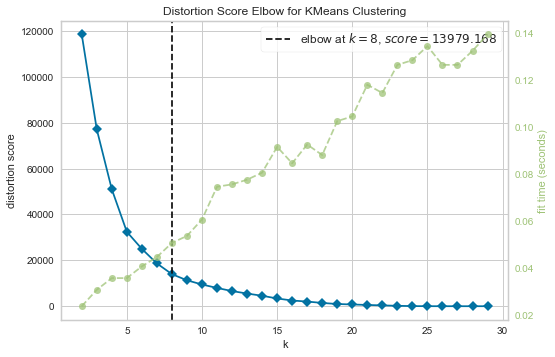

In [15]:
cust_loc = df[['cust_lat', 'cust_long']]
elbow_visualizer(cust_loc)

Elbow method is used to find the right value of k (number of cluster). Here, the scoring parameter metric is set to distortion, which computes the sum of squared distances from each point to its assigned center.

In [16]:
# K mean for customer address
kmeans_cust, labels = create_cluster(cust_loc, 8)
df['cust_cluster'] = labels

<AxesSubplot:xlabel='cust_lat', ylabel='cust_long'>

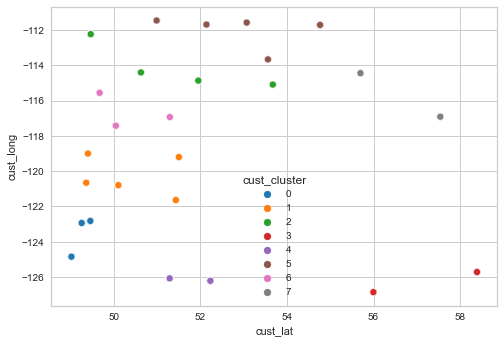

In [17]:
sns.scatterplot(x = 'cust_lat', y = 'cust_long', data = df, hue = 'cust_cluster', palette= "tab10")

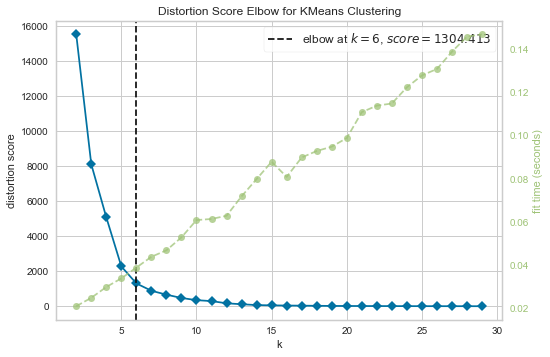

In [18]:
#K mean for store address
store_loc = df[['store_lat', 'store_long']] # dataframe with store location
elbow_visualizer(store_loc)

In [19]:
kmeans_store, labels = create_cluster(store_loc, 6)
df['store_cluster'] = labels

<AxesSubplot:xlabel='store_lat', ylabel='store_long'>

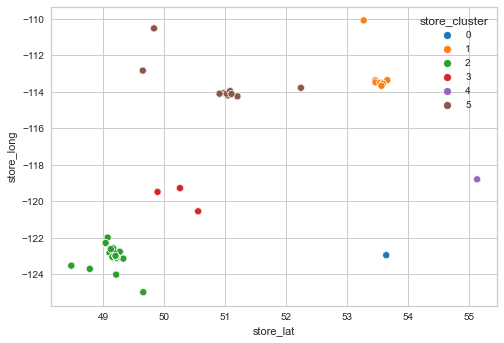

In [20]:
sns.scatterplot(x = 'store_lat', y = 'store_long', data = df, hue = 'store_cluster', palette= "tab10")

In [21]:
df.head()# After feature engineering

,Order-Date,Delivery-Date,Promised-Date,Courier,Size of the box height,Size of the box width,Size of the box length,Size of the box weight,Weather,Store address,Customer address,shipping_days,order_month,distance,cust_lat,cust_long,store_lat,store_long,cust_cluster,store_cluster
0,2021-01-24,2021-01-27,2021-01-26,PS,29.632656,34.722553,17.523058,3.807421,Good,"49.1534,-123.048","51.29548801984406,-126.07325247944962",3,January,321.473027,51.295488,-126.073252,49.1534,-123.048,4,2
1,2021-04-09,2021-04-13,2021-04-13,FD,29.632656,34.722553,17.523058,1.902088,Good,"49.1534,-123.048","51.29486187466757,-126.07255765553835",4,April,321.389102,51.294862,-126.072558,49.1534,-123.048,4,2
2,2021-09-27,2021-10-02,2021-10-02,PS,29.632656,34.722553,17.523058,2.152103,Good,"49.1534,-123.048","51.29566033167437,-126.07443435490822",5,September,321.543559,51.295660,-126.074434,49.1534,-123.048,4,2
3,2020-11-29,2020-12-04,2020-12-03,PS,29.632656,34.722553,17.523058,3.802455,Good,"49.1534,-123.048","51.295612714656855,-126.07310897909636",5,November,321.476244,51.295613,-126.073109,49.1534,-123.048,4,2
4,2021-09-06,2021-09-12,2021-09-11,FD,29.632656,34.722553,17.523058,5.510081,Good,"49.1534,-123.048","51.29454616285458,-126.07309709870711",6,September,321.389395,51.294546,-126.073097,49.1534,-123.048,4,2


In [22]:
orig_df = df.copy() # create a copy of the dataframe

## 4. Exploratory Data Analysis

EDA is used to find the data insights that can be further used to answer some interesting problems, and also in building models.

In [23]:
def hist_box_plot(data, column):
    """This function plots histogram and boxplot
    Input: Dataframe, Attrubute"""
    
    fig, axes = plt.subplots(1, 2,figsize=(8, 4)) #create two subplots in a single row
    
    sns.histplot(ax=axes[0], data=data, x = column) # plot histogram at (0,0)
    axes[0].set_title('Histogram') # set title
    
    sns.boxplot(x = data[column], ax=axes[1]) # plot box plot at (0,1)
    axes[1].set_title('Box Plot') # set title
    plt.show() # show plot

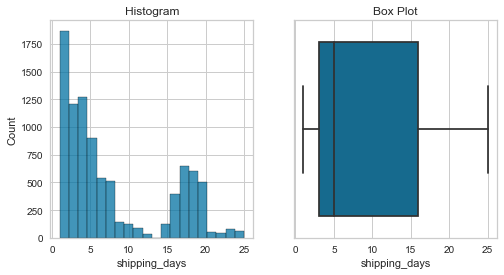

In [24]:
hist_box_plot(df, 'shipping_days')

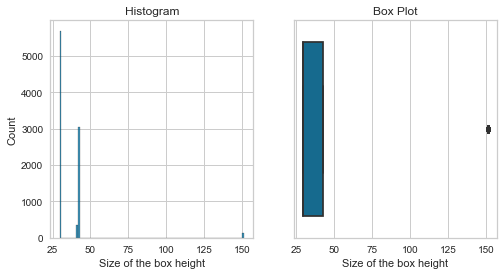

In [25]:
hist_box_plot(df, 'Size of the box height')

It can be seen from the boxplot that there are some outliers in the box height data. 

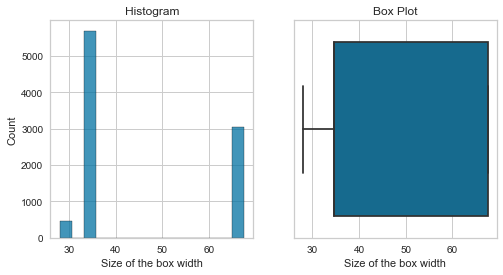

In [26]:
hist_box_plot(df, 'Size of the box width')

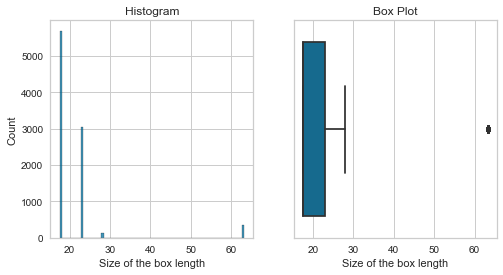

In [27]:
hist_box_plot(df, 'Size of the box length')

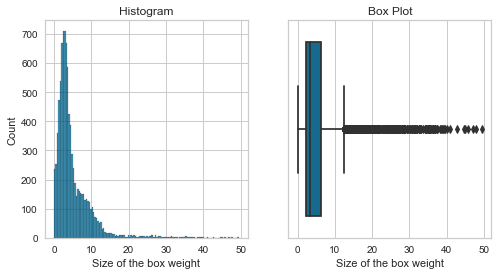

In [28]:
hist_box_plot(df, 'Size of the box weight')

Robust Scaler is used in the next part of the notebook to deal with the outliers.

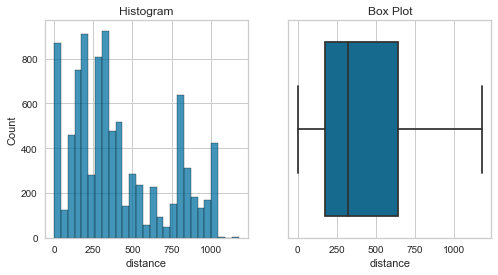

In [29]:
hist_box_plot(df, 'distance')

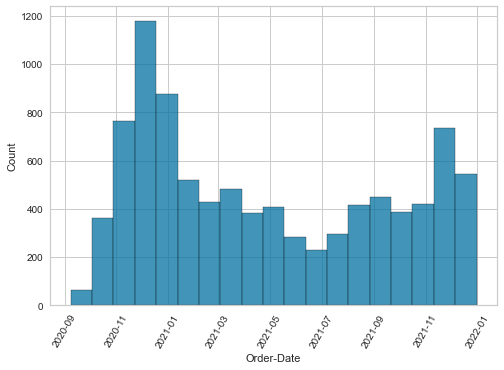

In [30]:
sns.histplot(data = df, x= 'Order-Date')
plt.xticks(rotation = 60)
plt.show()

In [31]:
def countplot(data, column):
    """This function plot the countplot
    Input: dataframe, attribute"""
    dd = data[column].value_counts(normalize=True, sort=False).reset_index() # calculate normalize value count
    sns.barplot(x = dd['index'], y = dd[column]) # plot bar plot
    plt.ylabel('Normalize Count')
    plt.show()

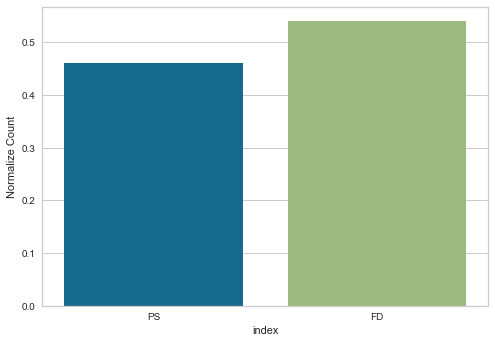

In [32]:
countplot(df, 'Courier')

It seems that FD got more product to ship than PS

### 4.1 Correlation Heatmap

<Figure size 576x576 with 0 Axes>

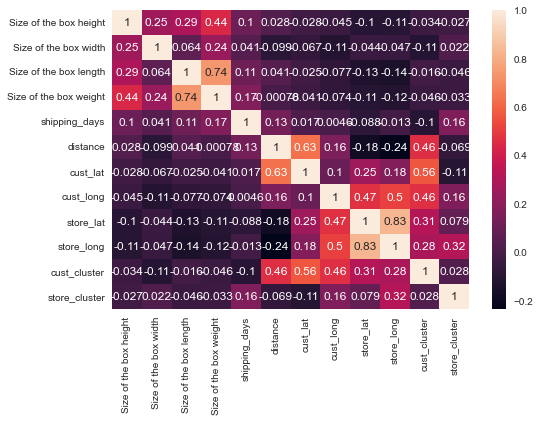

<Figure size 576x576 with 0 Axes>

In [33]:
sns.heatmap(df.corr(), annot=True) #plt heatmap for the corelation coefficients
plt.figure(figsize=(8, 8))

<AxesSubplot:xlabel='Size of the box weight', ylabel='shipping_days'>

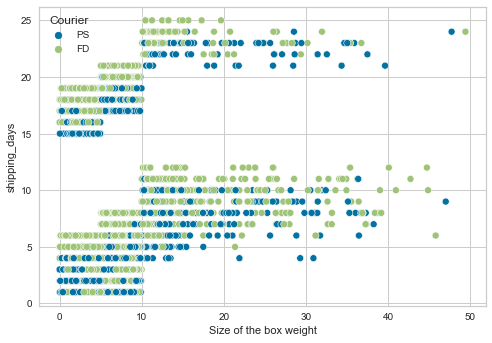

In [34]:
# How number of shipping days varies with the box weight
sns.scatterplot(data=df, x = 'Size of the box weight', y = 'shipping_days', hue='Courier') 

It's interesting to know that the number of shipping days increases with the size of the box weight 

<AxesSubplot:xlabel='Weather'>

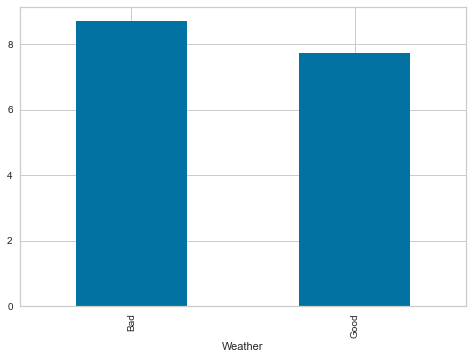

In [35]:
#Affect of weather on the mean shipping days
df.groupby('Weather')['shipping_days'].mean().plot.bar()

The mean shipping days in the bad weather are more those in good weather.

<AxesSubplot:xlabel='order_month'>

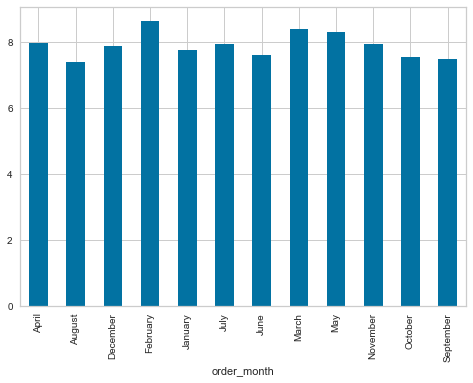

In [36]:
# Mean shipping days in each month
df.groupby('order_month')['shipping_days'].mean().plot.bar()

<AxesSubplot:xlabel='Courier'>

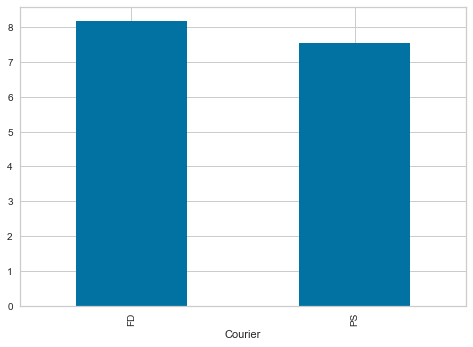

In [37]:
# Do shipping days depend on the courier company? 
df.groupby('Courier')['shipping_days'].mean().plot.bar()

<AxesSubplot:xlabel='store_cluster'>

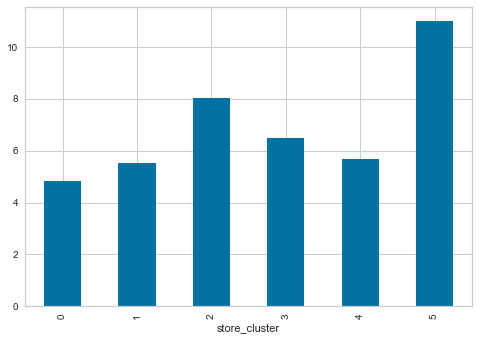

In [38]:
# Do shipping days depend on the store address? 
df.groupby('store_cluster')['shipping_days'].mean().plot.bar()

The store addresses in the cluster 5 takes more shipping days than the others

<AxesSubplot:xlabel='cust_cluster'>

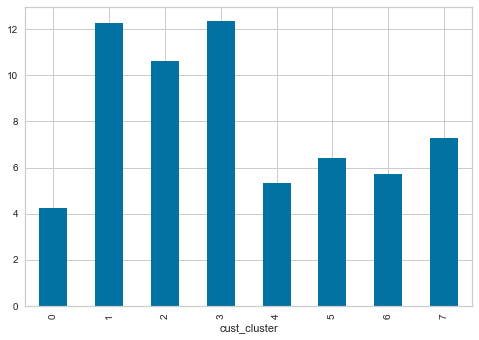

In [39]:
# Do shipping days depend on the customer address? 
df.groupby('cust_cluster')['shipping_days'].mean().plot.bar()

Some clusters such as 1 and 3 requires more time for delivery

## 5. Building Model

In [40]:
def make_x_y(data, drop_columns):
    """This function divides the data into dependent and independent variables"""
    df = data.drop(columns=drop_columns)
    y_col = 'shipping_days'
    x_col = [col for col in df.columns if col != y_col]
    y = df[y_col]
    x = df.loc[:, x_col]
    
    return x, y

In [41]:
drop_columns = ['Store address', 'Customer address', 'cust_lat', 'cust_long', 'store_lat',
                'store_long', 'Order-Date', 'Delivery-Date', 'Promised-Date']
x, y = make_x_y(orig_df, drop_columns)
print(x.shape, y.shape)

(9222, 10) (9222,)


In [42]:
def train_test(x, y, test_size = 0.2):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)
    return x_train, x_test, y_train, y_test

In [43]:
x_train, x_test, y_train, y_test = train_test(x, y)

In [44]:
def create_pipeline(scaler, scaler_cols, ohe_cols, model):
    """This functions create pipeline with one hot encoder and scaler"""
    column_trans = make_column_transformer((
    OneHotEncoder(drop='first'), ohe_cols),
    (scaler, scaler_cols),
    remainder = 'passthrough')
    pipe = Pipeline(steps = [('column_trans', column_trans), ('model', model)])
    return pipe

In [45]:
def create_gridsearchcv(pipe, param_dict, cv = 5, scoring = 'neg_root_mean_squared_error'):
    cv = GridSearchCV(pipe, param_grid = param_dict, cv = cv, scoring = scoring)
    return cv

In [46]:
def print_cv_result(cv):
    """This functions prints the results"""
    print(f'BEST PARAMETERS: {cv.best_params_}')
    means = cv.cv_results_['mean_test_score']
    stds = cv.cv_results_['std_test_score']
    params = cv.cv_results_['params']
    i=0
    for p, m, s in zip(params, means, stds):
        print(p, f'mean_test_score: {m}', f'std_test_score: {s}')
        i+=1

### 5.1 Ridge Regression

In [66]:
# Linear Regression with robust scaler
ohe_cols = ['Weather', 'Courier', 'order_month', 'cust_cluster', 'store_cluster']
scaler = RobustScaler()
scaler_cols = ['Size of the box height', 'Size of the box width',
               'Size of the box length', 'Size of the box weight', 'distance']
model = Ridge(normalize = False)
pipeline = create_pipeline(scaler, scaler_cols, ohe_cols, model)
param_dict = {"model__alpha":[0.001, 0.01, 0.1, 1, 10]}
cv = create_gridsearchcv(pipeline, param_dict, cv = 5, scoring = 'neg_root_mean_squared_error')

In [67]:
cv.fit(x_train, y_train)

D:\Anaconda\envs\adv_maths\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
D:\Anaconda\envs\adv_maths\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
D:\Anaconda\envs\adv_maths\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 

D:\Anaconda\envs\adv_maths\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
D:\Anaconda\envs\adv_maths\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
D:\Anaconda\envs\adv_maths\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Weather',
                                                                          'Courier',
                                                                          'order_month',
                                                                          'cust_cluster',
                                                                          'store_cluster']),
                                                                        ('robustscaler',
                                                                         RobustScaler(),
                              

In [68]:
print_cv_result(cv)

BEST PARAMETERS: {'model__alpha': 1}
{'model__alpha': 0.001} mean_test_score: -5.477808294708046 std_test_score: 0.08049327922160518
{'model__alpha': 0.01} mean_test_score: -5.477805066110264 std_test_score: 0.08048302806130136
{'model__alpha': 0.1} mean_test_score: -5.477774655367845 std_test_score: 0.0803814812676274
{'model__alpha': 1} mean_test_score: -5.477641055022414 std_test_score: 0.07944850283136053
{'model__alpha': 10} mean_test_score: -5.485317000576201 std_test_score: 0.07330025541986651


In [69]:
def find_mse(cv, x_train, y_train, x_test, y_test):
    y_test_hat = cv.predict(x_test)
    y_train_hat = cv.predict(x_train)
    mse_test = mean_squared_error(y_true=y_test, y_pred=y_test_hat)
    mse_train = mean_squared_error(y_true=y_train, y_pred=y_train_hat)
    return mse_test, mse_train

In [70]:
find_mse(cv, x_train, y_train, x_test, y_test)

(29.808313708647614, 29.732013351481402)

In [81]:
model_name = ['Ridge_rs']
# result = {'train_mse':[29.732013351481402], "test_mse": [29.808313708647614]}

### 5.2 Random forest

In [55]:
# Random forest with robust scaler
ohe_cols = ['Weather', 'Courier', 'order_month', 'cust_cluster', 'store_cluster']
scaler = RobustScaler()
scaler_cols = ['Size of the box height', 'Size of the box width',
               'Size of the box length', 'Size of the box weight', 'distance']
model = RandomForestRegressor(n_jobs=-1)
pipeline = create_pipeline(scaler, scaler_cols, ohe_cols, model)
param_dict = {"model__n_estimators":[10, 50, 100, 200, 500, 1000], "model__max_depth": [16, 64, None]}
cv = create_gridsearchcv(pipeline, param_dict, cv = 5, scoring = 'neg_root_mean_squared_error')

In [56]:
cv.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Weather',
                                                                          'Courier',
                                                                          'order_month',
                                                                          'cust_cluster',
                                                                          'store_cluster']),
                                                                        ('robustscaler',
                                                                         RobustScaler(),
                              

In [58]:
print_cv_result(cv)

BEST PARAMETERS: {'model__max_depth': 16, 'model__n_estimators': 500}
{'model__max_depth': 16, 'model__n_estimators': 10} mean_test_score: -1.917697153511518 std_test_score: 0.09104252879860293
{'model__max_depth': 16, 'model__n_estimators': 50} mean_test_score: -1.824015688272673 std_test_score: 0.09291142580780366
{'model__max_depth': 16, 'model__n_estimators': 100} mean_test_score: -1.8107879366137467 std_test_score: 0.08849494610900838
{'model__max_depth': 16, 'model__n_estimators': 200} mean_test_score: -1.8077700039679165 std_test_score: 0.09623413692581466
{'model__max_depth': 16, 'model__n_estimators': 500} mean_test_score: -1.8029682817060995 std_test_score: 0.08914516875727835
{'model__max_depth': 16, 'model__n_estimators': 1000} mean_test_score: -1.8038517867313217 std_test_score: 0.09259325413497395
{'model__max_depth': 64, 'model__n_estimators': 10} mean_test_score: -1.871767530589135 std_test_score: 0.10059660033914883
{'model__max_depth': 64, 'model__n_estimators': 50} m

In [69]:
def find_mse(cv, x_train, y_train, x_test, y_test):
    y_test_hat = cv.predict(x_test)
    y_train_hat = cv.predict(x_train)
    mse_test = mean_squared_error(y_true=y_test, y_pred=y_test_hat)
    mse_train = mean_squared_error(y_true=y_train, y_pred=y_train_hat)
    return mse_test, mse_train

In [62]:
find_mse(cv, x_train, y_train, x_test, y_test)

(3.12454170769266, 0.5713128459650793)

In [73]:
result['test_mse'].append(3.12454170769266)
result["train_mse"].append(0.5713128459650793)

In [82]:
model_name.append('Random_forest_rs')

### 5.3 Neural Network

In [57]:
column_trans = make_column_transformer((
    OneHotEncoder(drop='first'), ['Weather', 'Courier', 'order_month', 'cust_cluster', 'store_cluster']),
    (StandardScaler(), ['Size of the box height', 'Size of the box width',
               'Size of the box length', 'Size of the box weight', 'distance']),
    remainder = 'passthrough')
column_trans.fit(x_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                 ['Weather', 'Courier', 'order_month',
                                  'cust_cluster', 'store_cluster']),
                                ('standardscaler', StandardScaler(),
                                 ['Size of the box height',
                                  'Size of the box width',
                                  'Size of the box length',
                                  'Size of the box weight', 'distance'])])

In [58]:
x_train = column_trans.transform(x_train)
x_test = column_trans.transform(x_test)

In [60]:
model = Sequential()
model.add(Dense(16, input_dim=(30), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                496       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 673
Trainable params: 673
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.compile(loss=MeanSquaredError(), optimizer='adam', metrics=['mse'])

In [64]:
history = model.fit(x_train, y_train, epochs=200, validation_data=(x_test, y_test))

Epoch 1/200
231/231 [==============================] - 1s 4ms/step - loss: 38.9842 - mse: 38.9842 - val_loss: 36.2438 - val_mse: 36.2438
Epoch 2/200
231/231 [==============================] - 1s 3ms/step - loss: 34.3620 - mse: 34.3620 - val_loss: 32.7273 - val_mse: 32.7273
Epoch 3/200
231/231 [==============================] - 1s 3ms/step - loss: 31.8425 - mse: 31.8425 - val_loss: 31.0315 - val_mse: 31.0315
Epoch 4/200
231/231 [==============================] - 1s 3ms/step - loss: 30.6344 - mse: 30.6344 - val_loss: 30.1343 - val_mse: 30.1343
Epoch 5/200
231/231 [==============================] - 1s 3ms/step - loss: 29.5497 - mse: 29.5497 - val_loss: 29.1244 - val_mse: 29.1244
Epoch 6/200
231/231 [==============================] - 1s 3ms/step - loss: 28.1721 - mse: 28.1721 - val_loss: 27.2595 - val_mse: 27.2595
Epoch 7/200
231/231 [==============================] - 1s 3ms/step - loss: 26.3144 - mse: 26.3144 - val_loss: 25.2987 - val_mse: 25.2987
Epoch 8/200
231/231 [====================

Epoch 61/200
231/231 [==============================] - 1s 3ms/step - loss: 7.6146 - mse: 7.6146 - val_loss: 9.9574 - val_mse: 9.9574
Epoch 62/200
231/231 [==============================] - 1s 3ms/step - loss: 7.5578 - mse: 7.5578 - val_loss: 9.9102 - val_mse: 9.9102
Epoch 63/200
231/231 [==============================] - 1s 3ms/step - loss: 7.5245 - mse: 7.5245 - val_loss: 9.7282 - val_mse: 9.7282
Epoch 64/200
231/231 [==============================] - 1s 3ms/step - loss: 7.5051 - mse: 7.5051 - val_loss: 9.9767 - val_mse: 9.9767
Epoch 65/200
231/231 [==============================] - 1s 3ms/step - loss: 7.4440 - mse: 7.4440 - val_loss: 9.7986 - val_mse: 9.7986
Epoch 66/200
231/231 [==============================] - 1s 3ms/step - loss: 7.4868 - mse: 7.4868 - val_loss: 9.7108 - val_mse: 9.7108
Epoch 67/200
231/231 [==============================] - 1s 3ms/step - loss: 7.3959 - mse: 7.3959 - val_loss: 9.7499 - val_mse: 9.7499
Epoch 68/200
231/231 [==============================] - 1s 3ms

Epoch 122/200
231/231 [==============================] - 1s 3ms/step - loss: 6.5909 - mse: 6.5909 - val_loss: 9.3688 - val_mse: 9.3688
Epoch 123/200
231/231 [==============================] - 1s 3ms/step - loss: 6.5626 - mse: 6.5626 - val_loss: 9.5267 - val_mse: 9.5267
Epoch 124/200
231/231 [==============================] - 1s 3ms/step - loss: 6.4988 - mse: 6.4988 - val_loss: 9.3116 - val_mse: 9.3116
Epoch 125/200
231/231 [==============================] - 1s 3ms/step - loss: 6.5358 - mse: 6.5358 - val_loss: 9.2771 - val_mse: 9.2771
Epoch 126/200
231/231 [==============================] - 1s 3ms/step - loss: 6.5236 - mse: 6.5236 - val_loss: 9.2653 - val_mse: 9.2653
Epoch 127/200
231/231 [==============================] - 1s 3ms/step - loss: 6.4746 - mse: 6.4746 - val_loss: 9.2829 - val_mse: 9.2829
Epoch 128/200
231/231 [==============================] - 1s 3ms/step - loss: 6.5240 - mse: 6.5240 - val_loss: 9.3348 - val_mse: 9.3348
Epoch 129/200
231/231 [==============================] 

In [66]:
def get_history(metric, title, ylabel):
    """ This function is used to plot the history (loss and metrics) with respect to epochs"""
    
    plt.plot(history.history[metric])   # to plot metrics for training data
    plt.plot(history.history['val_' + metric])   # to plot metrics for validataion data
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

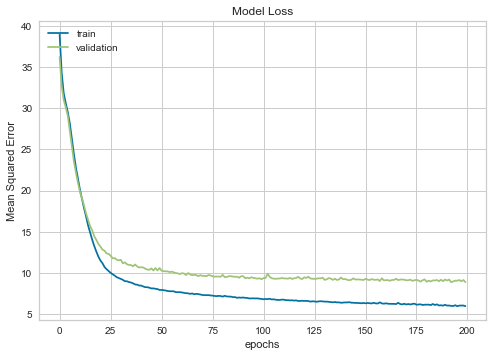

In [67]:
get_history('mse', 'Model Loss', 'Mean Squared Error')

In [70]:
find_mse(model, x_train, y_train, x_test, y_test)

(8.870107591072449, 5.8275565148250505)

In [74]:
result['test_mse'].append(8.870107591072449)
result["train_mse"].append(5.8275565148250505)

In [83]:
model_name.append('NN_ss')

It seems that the error in the neural network predictions are more than the random forest. 

### 5.4 Random Forest with robust scaler and order month deleted

In [63]:
drop_columns = ['Store address', 'Customer address', 'cust_lat', 'cust_long', 'store_lat',
                'store_long', 'Order-Date', 'Delivery-Date', 'Promised-Date', 'order_month']
x, y = make_x_y(orig_df, drop_columns)
print(x.shape, y.shape)

(9222, 9) (9222,)


In [64]:
x_train, x_test, y_train, y_test = train_test(x, y)

In [65]:
# Random forest with robust scaler
ohe_cols = ['Weather', 'Courier', 'cust_cluster', 'store_cluster']
scaler = RobustScaler()
scaler_cols = ['Size of the box height', 'Size of the box width',
               'Size of the box length', 'Size of the box weight', 'distance']
model = RandomForestRegressor(n_jobs=-1)
pipeline = create_pipeline(scaler, scaler_cols, ohe_cols, model)
param_dict = {"model__n_estimators":[10, 50, 100, 200, 500, 1000], "model__max_depth": [16, 64, None]}
rf_cv = create_gridsearchcv(pipeline, param_dict, cv = 5, scoring = 'neg_root_mean_squared_error')

In [66]:
rf_cv.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Weather',
                                                                          'Courier',
                                                                          'cust_cluster',
                                                                          'store_cluster']),
                                                                        ('robustscaler',
                                                                         RobustScaler(),
                                                                         ['Size '
                                     

In [67]:
print_cv_result(rf_cv)

BEST PARAMETERS: {'model__max_depth': 16, 'model__n_estimators': 1000}
{'model__max_depth': 16, 'model__n_estimators': 10} mean_test_score: -1.8065484374438874 std_test_score: 0.1175975663604042
{'model__max_depth': 16, 'model__n_estimators': 50} mean_test_score: -1.7424104497171087 std_test_score: 0.09710264087936799
{'model__max_depth': 16, 'model__n_estimators': 100} mean_test_score: -1.7298382922532507 std_test_score: 0.09359954072313477
{'model__max_depth': 16, 'model__n_estimators': 200} mean_test_score: -1.7300847808340165 std_test_score: 0.09418846283225793
{'model__max_depth': 16, 'model__n_estimators': 500} mean_test_score: -1.726135039187022 std_test_score: 0.09570036995692083
{'model__max_depth': 16, 'model__n_estimators': 1000} mean_test_score: -1.7195750664055924 std_test_score: 0.10273953548249826
{'model__max_depth': 64, 'model__n_estimators': 10} mean_test_score: -1.786819057993684 std_test_score: 0.07807484641051989
{'model__max_depth': 64, 'model__n_estimators': 50} 

In [69]:
find_mse(rf_cv, x_train, y_train, x_test, y_test)

(2.6395044686070315, 0.5201847655532031)

In [75]:
result['test_mse'].append(2.6395044686070315,)
result["train_mse"].append(0.5201847655532031)

In [85]:
model_name.append('Random_forest_wo_order_month')

The error decreases by removing the order_month feature.

### 5.5 Outlier removed

In [111]:
def remove_outlier(data, column):
    """This function is used to remove the outlier"""
    q3 = data[column].quantile(0.75)# third quartile
    q1 = data[column].quantile(0.25)# first quartile
    IQR = q3 - q1
    lower_outlier = data[column] < (q3 + 1.5*IQR)
    upper_outlier = data[column] > (q1 - 1.5*IQR)
    df_trim = data[(lower_outlier) & (upper_outlier)] #after removing the outlierts
    
    return df_trim

In [112]:
df_trim = remove_outlier(orig_df, 'Size of the box weight')
df_trim = remove_outlier(df_trim, 'Size of the box height')
df_trim = remove_outlier(df_trim, 'Size of the box width')
df_trim = remove_outlier(df_trim, 'Size of the box length')

In [113]:
df_trim.shape

(8578, 20)

In [73]:
drop_columns = ['Store address', 'Customer address', 'cust_lat', 'cust_long', 'store_lat',
                'store_long', 'Order-Date', 'Delivery-Date', 'Promised-Date', 'order_month']
x, y = make_x_y(df_trim, drop_columns)
print(x.shape, y.shape)

(8578, 9) (8578,)


In [74]:
x_train, x_test, y_train, y_test = train_test(x, y)

In [75]:
# Random forest with robust scaler
ohe_cols = ['Weather', 'Courier', 'cust_cluster', 'store_cluster']
scaler = RobustScaler()
scaler_cols = ['Size of the box height', 'Size of the box width',
               'Size of the box length', 'Size of the box weight', 'distance']
model = RandomForestRegressor(n_jobs=-1)
pipeline = create_pipeline(scaler, scaler_cols, ohe_cols, model)
param_dict = {"model__n_estimators":[10, 50, 100, 200, 500, 1000], "model__max_depth": [16, 64, None]}
rf_cv_trim = create_gridsearchcv(pipeline, param_dict, cv = 5, scoring = 'neg_root_mean_squared_error')

In [76]:
rf_cv_trim.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Weather',
                                                                          'Courier',
                                                                          'cust_cluster',
                                                                          'store_cluster']),
                                                                        ('robustscaler',
                                                                         RobustScaler(),
                                                                         ['Size '
                                     

In [77]:
print_cv_result(rf_cv_trim)

BEST PARAMETERS: {'model__max_depth': 16, 'model__n_estimators': 1000}
{'model__max_depth': 16, 'model__n_estimators': 10} mean_test_score: -1.8822293211463872 std_test_score: 0.06213374449793633
{'model__max_depth': 16, 'model__n_estimators': 50} mean_test_score: -1.820032883950874 std_test_score: 0.06012963780645756
{'model__max_depth': 16, 'model__n_estimators': 100} mean_test_score: -1.815234191297775 std_test_score: 0.06769716514070982
{'model__max_depth': 16, 'model__n_estimators': 200} mean_test_score: -1.7996865449178188 std_test_score: 0.058350283527350444
{'model__max_depth': 16, 'model__n_estimators': 500} mean_test_score: -1.8021205488553398 std_test_score: 0.05838285794664832
{'model__max_depth': 16, 'model__n_estimators': 1000} mean_test_score: -1.7982614283144767 std_test_score: 0.06312246781227311
{'model__max_depth': 64, 'model__n_estimators': 10} mean_test_score: -1.8831028554370206 std_test_score: 0.06073360164989501
{'model__max_depth': 64, 'model__n_estimators': 50

In [78]:
find_mse(rf_cv_trim, x_train, y_train, x_test, y_test)

(2.627959128905869, 0.5092783864601348)

In [76]:
result['test_mse'].append(2.627959128905869,)
result["train_mse"].append(0.5092783864601348)

In [86]:
model_name.append('Random_forest_outlier_removed')

By removing the outliers, the accuracy is further increased.

## 5. Feature Selection

In [148]:
# Built an auto feature selection tool
"""


@author: Robin
"""
import numpy as np
import pandas as pd 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

def cor_selector(X, y,num_feats):
    
    cor_list = []
    feature_name = X.columns.tolist()
    
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    
    cor_support = [True if i in cor_feature else False for i in feature_name]
    
    return cor_support, cor_feature

def chi_squared_selector(X, y, num_feats):
    
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(score_func=chi2, k=num_feats)
    chi_selector.fit(X_norm,y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:, chi_support].columns.to_list()
    
    return chi_support, chi_feature

def rfe_selector(X, y, num_feats):
    
    scaler = MinMaxScaler()
    X_norm = scaler.fit_transform(X)
    model = LogisticRegression(class_weight= 'balanced',
                               solver= 'lbfgs',
                               random_state=42,
                               n_jobs= -1,
                               max_iter= 500)
    rfe_sel = RFE(estimator=model,
                  n_features_to_select= num_feats,
                 step = 10)
    rfe_sel.fit(X_norm, y)
    rfe_support = rfe_sel.get_support()
    rfe_feature = X.loc[:, rfe_support].columns.to_list()
    
    return rfe_support, rfe_feature

def embedded_log_reg_selector(X, y, num_feats):
    
    scaler = MinMaxScaler()
    X_norm = scaler.fit_transform(X)
    model = LogisticRegression(penalty='l1', solver= 'saga', max_iter= 500)
    emb_sel = SelectFromModel(estimator=model, max_features= num_feats)
    emb_sel.fit(X_norm, y)
    embedded_lr_support = emb_sel.get_support()
    embedded_lr_feature = X.loc[:, embedded_lr_support].columns.to_list()
    
    return embedded_lr_support, embedded_lr_feature

def embedded_rf_selector(X, y, num_feats):
    
    scaler = MinMaxScaler()
    X_norm = scaler.fit_transform(X)
    model = RandomForestClassifier(n_estimators=100)
    emb_rf_sel = SelectFromModel(estimator=model, max_features= num_feats)
    emb_rf_sel.fit(X_norm, y)
    embedded_rf_support = emb_rf_sel.get_support()
    embedded_rf_feature = X.loc[:, embedded_rf_support].columns.to_list()
    
    return embedded_rf_support, embedded_rf_feature

def embedded_lgbm_selector(X, y, num_feats):
    
    scaler = MinMaxScaler()
    X_norm = scaler.fit_transform(X)
    model = LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
    emb_lgbm_sel = SelectFromModel(estimator=model, max_features= num_feats)
    emb_lgbm_sel.fit(X_norm, y)
    embedded_lgbm_support = emb_lgbm_sel.get_support()
    embedded_lgbm_feature = X.loc[:, embedded_lgbm_support].columns.to_list()
    
    return embedded_lgbm_support, embedded_lgbm_feature

def preprocess_dataset(dataset_path):
    
    df = pd.read_csv(dataset_path)
    numcols = ['Size of the box height', 'Size of the box width', 'Size of the box length', 'Size of the box weight', 'shipping_days', 'distance']
    catcols = ['Courier', 'Weather', 'cust_cluster', 'store_cluster']
    df = df[numcols+catcols]
    traindf = pd.concat([df[numcols], pd.get_dummies(df[catcols], drop_first = True)],axis=1)
    features = traindf.columns
    traindf = traindf.dropna()
    traindf = pd.DataFrame(traindf,columns=features)
    y_col = 'shipping_days'
    x_col = [col for col in traindf.columns if col != y_col]
    y = traindf[y_col]
    x = traindf.loc[:, x_col]

    return x, y

def autoFeatureSelector(dataset_path, num_feats, methods=[]):
    # Parameters
    # data - dataset to be analyzed (csv file)
    # methods - various feature selection methods we outlined before, use them all here (list)
    
    # preprocessing
    X, y = preprocess_dataset(dataset_path)
    feature_name = X.columns.to_list()
    #print(feature_name)
    
    # Run every method we outlined above from the methods list and collect returned best features from every method
    if 'pearson' in methods:
        cor_support, cor_feature = cor_selector(X, y,num_feats)
    if 'chi-square' in methods:
        chi_support, chi_feature = chi_squared_selector(X, y,num_feats)
    if 'rfe' in methods:
        rfe_support, rfe_feature = rfe_selector(X, y,num_feats)
    if 'log-reg' in methods:
        embedded_lr_support, embedded_lr_feature = embedded_log_reg_selector(X, y, num_feats)
    if 'rf' in methods:
        embedded_rf_support, embedded_rf_feature = embedded_rf_selector(X, y, num_feats)
    if 'lgbm' in methods:
        embedded_lgbm_support, embedded_lgbm_feature = embedded_lgbm_selector(X, y, num_feats)
    
    
    # Combine all the above feature list and count the maximum set of features that got selected by all methods
    
    feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embedded_lr_support,
                                    'Random Forest':embedded_rf_support, 'LightGBM':embedded_lgbm_support})
    # count the selected times for each feature
    feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
    
    feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
    feature_selection_df.index = range(1, len(feature_selection_df)+1)
    best_features = feature_selection_df['Feature'].tolist()[:num_feats]
    
    return best_features

In [79]:
best_features = autoFeatureSelector('new.csv', methods=['pearson', 'chi-square', 'rfe', 'log-reg', 'rf', 'lgbm'], num_feats = 9)

D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:85: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return reduction(axis=axis, out=out, **passkwargs)


In [80]:
best_features# top features

['distance',
 'Size of the box weight',
 'store_cluster',
 'cust_cluster',
 'Weather_Good',
 'Size of the box width',
 'Size of the box length',
 'Size of the box height',
 'Courier_PS']

In [114]:
y_col = 'shipping_days'
x_col = ['distance','Size of the box weight','store_cluster','cust_cluster','Weather', 'Size of the box width', 'Courier']
y = df_trim[y_col]
x = df_trim.loc[:, x_col]

In [115]:
print(x.shape, y.shape)

(8578, 7) (8578,)


In [116]:
x_train, x_test, y_train, y_test = train_test(x, y)

In [120]:
# Random forest with robust scaler
ohe_cols = ['Weather', 'Courier', 'cust_cluster', 'store_cluster']
scaler = RobustScaler()
scaler_cols = ['Size of the box width', 'Size of the box weight', 'distance']
model = RandomForestRegressor(n_jobs=-1)
pipeline = create_pipeline(scaler, scaler_cols, ohe_cols, model)
param_dict = {"model__n_estimators":[10, 50, 100, 200, 500, 1000], "model__max_depth": [16, 64, None]}
rf_cv_trim_best = create_gridsearchcv(pipeline, param_dict, cv = 5, scoring = 'neg_root_mean_squared_error')

In [121]:
rf_cv_trim_best.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Weather',
                                                                          'Courier',
                                                                          'cust_cluster',
                                                                          'store_cluster']),
                                                                        ('robustscaler',
                                                                         RobustScaler(),
                                                                         ['Size '
                                     

In [124]:
print_cv_result(rf_cv_trim_best)

BEST PARAMETERS: {'model__max_depth': 16, 'model__n_estimators': 200}
{'model__max_depth': 16, 'model__n_estimators': 10} mean_test_score: -1.8621273598724273 std_test_score: 0.0419773602904905
{'model__max_depth': 16, 'model__n_estimators': 50} mean_test_score: -1.8363499816400897 std_test_score: 0.06774694456817673
{'model__max_depth': 16, 'model__n_estimators': 100} mean_test_score: -1.8051552853512873 std_test_score: 0.05056591921080959
{'model__max_depth': 16, 'model__n_estimators': 200} mean_test_score: -1.7964674587930252 std_test_score: 0.05592885855558104
{'model__max_depth': 16, 'model__n_estimators': 500} mean_test_score: -1.8002344239452612 std_test_score: 0.06837268398211982
{'model__max_depth': 16, 'model__n_estimators': 1000} mean_test_score: -1.7986179890720329 std_test_score: 0.059696800038048954
{'model__max_depth': 64, 'model__n_estimators': 10} mean_test_score: -1.9020243466564928 std_test_score: 0.040387591377580426
{'model__max_depth': 64, 'model__n_estimators': 5

In [125]:
find_mse(rf_cv_trim_best, x_train, y_train, x_test, y_test)

(2.6450688896411285, 0.5135475667965765)

In [77]:
result['test_mse'].append(2.6450688896411285,)
result["train_mse"].append(0.5135475667965765)

In [87]:
model_name.append('Random_forest_selected_festure')

The test and training error both improved by using the feature selection.

In [129]:
pickle.dump(rf_cv_trim_best, open('rf_cv_trim_best.pkl', 'wb'))#save trained model

## 7. Result

In [88]:
pd.DataFrame(result, index=model_name)

,train_mse,test_mse
Ridge_rs,29.732013,29.808314
Random_forest_rs,0.571313,3.124542
NN_ss,5.827557,8.870108
Random_forest_wo_order_month,0.520185,2.639504
Random_forest_outlier_removed,0.509278,2.627959
Random_forest_selected_festure,0.513548,2.645069


## 8. Prediction

In [106]:
def test_data_preprocess(df):
    """This function preprocesses the test data."""
    df['Store address'] = df['Store address'].apply(lat_long_format) # apply lat_long function to 'Store address' pandas series
    df['Customer address'] = df['Customer address'].apply(lat_long_format)
    
    for i in range(df.shape[0]):
        """Looping through the each row of the dataframe"""
        coordinate1 = df.loc[i,'Store address']
        coordinate2 = df.loc[i, 'Customer address']
        df.loc[i,'distance'] = distance(coordinate1, coordinate2)
        
    df['cust_lat'] = extract_lat_long(df, 'Customer address', 'latitude') # customer latitude
    df['cust_long'] = extract_lat_long(df, 'Customer address', 'longitude') # customer longitude
    df['store_lat'] = extract_lat_long(df, 'Store address', 'latitude') # Store latitude
    df['store_long'] = extract_lat_long(df, 'Store address', 'longitude') # Store longitude
    
    df['cust_cluster'] = kmeans_cust.predict(df[['cust_lat', 'cust_long']])
    df['store_cluster'] = kmeans_store.predict(df[['store_lat', 'store_long']])
    
    
    return df

In [146]:
def prediction(model, in_cols, path):
    
    df_test = pd.read_csv(path)
    df_test = test_data_preprocess(df_test)
    x_test = df_test.loc[:, in_cols]
    pred = model.predict(x_test)
    pred_dic = {'shipping_days': pred}
    pd.DataFrame(pred_dic).to_csv('robin_manchanda.csv', index=False)
    
    return pred

In [147]:
in_cols = ['distance','Size of the box weight','store_cluster','cust_cluster','Weather', 'Size of the box width', 'Courier']
pred = prediction(rf_cv_trim_best, in_cols, 'data_test.csv')

# How do you justify your proposed model?

Two different models i.e. artificial neural network and random forest have been used, but random forest outperforms the neural network in terms of mean squared error. Also, the random forest produces good predictions that can be understood easily. Other algorithms, such as Poisson regression was used but the mean squared error was very high as compared to the random forest.

## 9. App Deployed:
https://bb-delivery-estimate.herokuapp.com/